In [41]:
import os
# os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist
# import geoopt
import manifolds
import layers.hyp_layers as hyp_layers
import utils.math_utils as pmath
import optimizers
import matplotlib.pyplot as plt
import pandas as pd

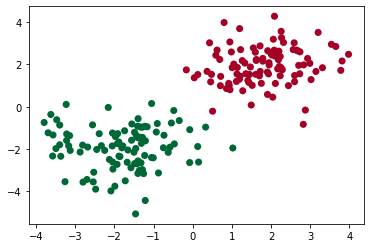

In [42]:
n_data = torch.ones(100, 2)
x0 = torch.normal(2*n_data, 1)
y0 = torch.zeros(100)
x1 = torch.normal(-2*n_data, 1)
y1 = torch.ones(100)

x = torch.cat((x0, x1), 0).type(torch.FloatTensor)  # FloatTensor = 32-bit floating
y = torch.cat((y0, y1), ).type(torch.LongTensor)    # LongTensor = 64-bit integer

plt.scatter(x.detach().numpy()[:, 0], x.detach().numpy()[:, 1], c=y.detach().numpy(), s=50, lw=0, cmap='RdYlGn')
plt.show()

In [43]:
"""
args
"""
class config_args():
    def __init__(self):
        self.manifold = 'PoincareBall' # which manifold to use, can be any of [Euclidean, Hyperboloid, PoincareBall]
        self.dropout = 0.0
        self.bias = 1
        self.c = 1.0
        self.num_layers = 2
        self.cuda = -1 # which cuda device to use (-1 for cpu training)
        self.act = 'relu'
        self.dim = 128 # embedding dimension
        self.task = 'None'
        self.optimizer = 'RiemannianAdam' # which optimizer to use, can be any of [Adam, RiemannianAdam]
        self.lr = 0.01
        self.weight_decay = 0.
    
args = config_args()
args.feat_dim = x.shape[1]
args.n_classes = 2
print(args.feat_dim)

# model2decoder = {
#     'GCN': GCNDecoder,
#     'GAT': GATDecoder,
#     'HNN': LinearDecoder,
#     'HGCN': LinearDecoder,
#     'MLP': LinearDecoder,
#     'Shallow': LinearDecoder,
# }

2


In [44]:
class Encoder(nn.Module):
    """
    Encoder abstract class.
    """

    def __init__(self, c):
        super(Encoder, self).__init__()
        self.c = c

    def encode(self, x, adj):
        if self.encode_graph:
            input = (x, adj)
            output, _ = self.layers.forward(input)
        else:
            output = self.layers.forward(x)
        return output

In [45]:
class HNN(Encoder):
    """
    Hyperbolic Neural Networks.
    """

    def __init__(self, c, args):
        super(HNN, self).__init__(c)
        self.manifold = getattr(manifolds, args.manifold)()
        assert args.num_layers > 1
        dims, acts, _ = hyp_layers.get_dim_act_curv(args)
        hnn_layers = []
        for i in range(len(dims) - 1):
            in_dim, out_dim = dims[i], dims[i + 1]
            act = acts[i]
            hnn_layers.append(
                    hyp_layers.HNNLayer(
                            self.manifold, in_dim, out_dim, self.c, args.dropout, act, args.bias)
            )
        self.layers = nn.Sequential(*hnn_layers)
        self.encode_graph = False

    def encode(self, x, adj):
        x_hyp = self.manifold.proj(self.manifold.expmap0(self.manifold.proj_tan0(x, self.c), c=self.c), c=self.c)
        return super(HNN, self).encode(x_hyp, adj)

In [46]:
class Decoder(nn.Module):
    """
    Decoder abstract class for node classification tasks.
    """

    def __init__(self, c):
        super(Decoder, self).__init__()
        self.c = c

    def decode(self, x, adj):
        if self.decode_adj:
            input = (x, adj)
            probs, _ = self.cls.forward(input)
        else:
            probs = self.cls.forward(x)
        return probs

In [47]:
class LinearDecoder(Decoder):
    """
    MLP Decoder for Hyperbolic/Euclidean node classification models.
    """

    def __init__(self, c, args):
        super(LinearDecoder, self).__init__(c)
        self.manifold = getattr(manifolds, args.manifold)()
        self.input_dim = args.dim
        self.output_dim = args.n_classes
        self.bias = args.bias
        self.cls = hyp_layers.Linear(self.input_dim, self.output_dim, args.dropout, lambda x: x, self.bias)
        self.decode_adj = False

    def decode(self, x, adj):
        h = self.manifold.proj_tan0(self.manifold.logmap0(x, c=self.c), c=self.c)
        return super(LinearDecoder, self).decode(h, adj)

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}, c={}'.format(
                self.input_dim, self.output_dim, self.bias, self.c
        )

In [48]:
class BaseModel(nn.Module):
    def __init__(self, args):
        super(BaseModel, self).__init__()
        self.manifold_name = args.manifold
        if args.c is not None:
            self.c = torch.tensor([args.c])
            if not args.cuda == -1:
                self.c = self.c.to(args.device)
        else:
            self.c = nn.Parameter(torch.Tensor([1.]))
        self.manifold = getattr(manifolds, self.manifold_name)()
        if self.manifold.name == 'Hyperboloid':
            args.feat_dim = args.feat_dim + 1
        self.encoder = HNN(self.c, args)
        self.decoder = LinearDecoder(self.c, args)
    
    def encode(self, x, adj = None):
        if self.manifold.name == 'Hyperboloid':
            o = torch.zeros_like(x)
            x = torch.cat([o[:, 0:1], x], dim=1)
        h = self.encoder.encode(x, adj)
        return h

    def decode(self, h, adj = None):
        output = self.decoder.decode(h, adj)
        return F.log_softmax(output, dim=1)
    
    def compute_metrics(self, embeddings, label):
        output = self.decode(embeddings)
        loss = F.nll_loss(output, label)
        acc, f1 = None, None
        metrics = {'loss': loss, 'acc': acc, 'f1': f1}
        return metrics, output

In [49]:
model = BaseModel(args)
optimizer = getattr(optimizers, args.optimizer)(params=model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(
#         optimizer,
#         step_size=int(args.lr_reduce_freq),
#         gamma=float(args.gamma)
#     )

In [50]:
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    embeddings = model.encode(x)
    train_metrics, output = model.compute_metrics(embeddings, y)
    print(train_metrics['loss'])
    train_metrics['loss'].backward()
    optimizer.step()
    # lr_scheduler.step()
    if epoch % 10 == 0:
        plt.cla()
        prediction = torch.max(F.softmax(output), 1)[1]
        pred_y = prediction.data.numpy().squeeze()
        target_y = y.data.numpy()
        plt.scatter(x.data.numpy()[:, 0], x.data.numpy()[:, 1], c=pred_y, s=100, lw=0, cmap='RdYlGn')
        accuracy = sum(pred_y == target_y)/200.  # 预测中有多少和真实值一样
        plt.text(1.5, -4, 'Accuracy=%.2f' % accuracy, fontdict={'size': 20, 'color':  'red'})
        plt.pause(0.1)
    
    

tensor(0.7248, grad_fn=<NllLossBackward0>)
tensor(0.6977, grad_fn=<NllLossBackward0>)
tensor(0.6698, grad_fn=<NllLossBackward0>)
tensor(0.6370, grad_fn=<NllLossBackward0>)
tensor(0.5995, grad_fn=<NllLossBackward0>)
tensor(0.5587, grad_fn=<NllLossBackward0>)
tensor(0.5161, grad_fn=<NllLossBackward0>)
tensor(0.4734, grad_fn=<NllLossBackward0>)
tensor(0.4322, grad_fn=<NllLossBackward0>)
tensor(0.3938, grad_fn=<NllLossBackward0>)
tensor(0.3589, grad_fn=<NllLossBackward0>)
tensor(0.3280, grad_fn=<NllLossBackward0>)
tensor(0.3015, grad_fn=<NllLossBackward0>)
tensor(0.2784, grad_fn=<NllLossBackward0>)
tensor(0.2584, grad_fn=<NllLossBackward0>)
tensor(0.2409, grad_fn=<NllLossBackward0>)
tensor(0.2258, grad_fn=<NllLossBackward0>)
tensor(0.2128, grad_fn=<NllLossBackward0>)
tensor(0.2012, grad_fn=<NllLossBackward0>)
tensor(0.1909, grad_fn=<NllLossBackward0>)
tensor(0.1813, grad_fn=<NllLossBackward0>)
tensor(0.1725, grad_fn=<NllLossBackward0>)
tensor(0.1643, grad_fn=<NllLossBackward0>)
tensor(0.15